# Figure courbe neurométrique MotionClouds
Variation de l'ouverture de courbe en fonction du b_theta dans la stimulation de MC, sur plusieurs pénétrations (il faut faire retourner le notebook à chaque fois)

# Extracting photodiode data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import KwikTools as kt
from tqdm import tqdm
import csv

In [2]:
subfolder = 'H006_a17/'

In [3]:
dataset = kt.load(subfolder+'/experiment1_100.raw.kwd',
                  'all')

info = dataset['info']['0']
data = dataset['data']['0']
channels = dataset['channel_bit_volts']['0']
timestamps = dataset['timestamps']['0']

In [4]:
print('Timestamps shape', timestamps.shape)
print('Timestamps range from %s to %s' % (timestamps.min(), timestamps.max()))
print('Which should be %s seconds' % (timestamps.max() - timestamps.min()))

Timestamps shape (91212300,)
Timestamps range from 8404.71 to 11445.119966666667
Which should be 3040.409966666668 seconds


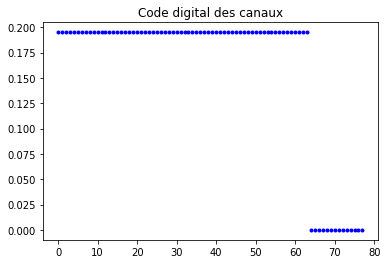

In [5]:
plt.plot(channels, '.b')
plt.title('Code digital des canaux')
plt.show()
plt.close('all')

plt.figure(figsize=(10, 6))
plt.plot(data[:,35][::10], linewidth=1)
plt.title("Photodiode signal, zoom on a peak, get the amplitude and the inter peak and multiply by 100")
plt.show()

plt.plot(data[:,70][::10])
plt.pause(.1)
plt.close('all')

In [6]:
photodiode_channel = data[:, 70]
del data

In [7]:
# https://stackoverflow.com/questions/15800895/finding-clusters-of-numbers-in-a-list
def grouper(iterable, timeframe):
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= timeframe:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group


above_threshold = np.where(photodiode_channel > 1720)[0]
chunk_list = list(enumerate(grouper(above_threshold, 600), 1))
print('Found %s chunks' % len(chunk_list))

Found 1441 chunks


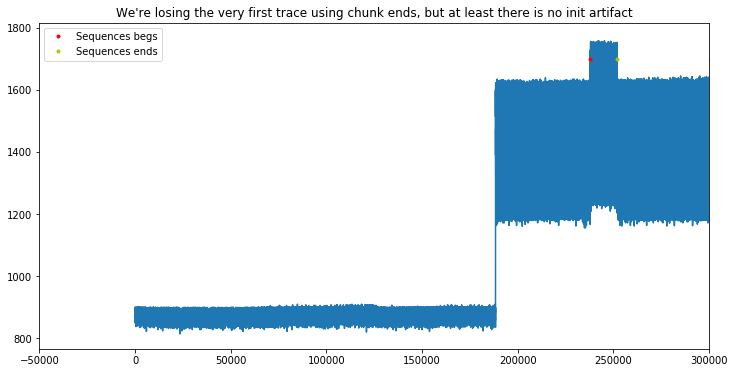

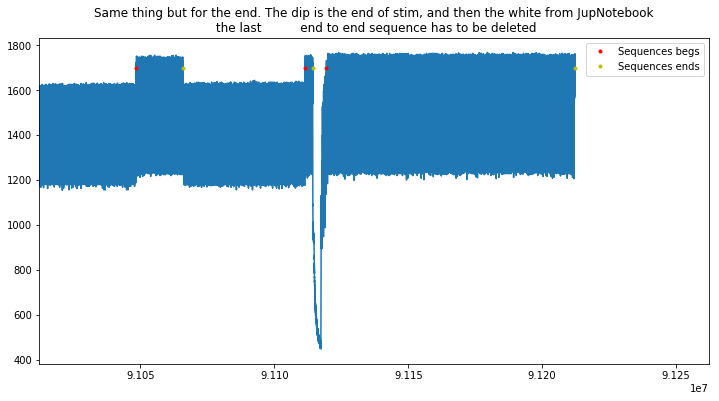

In [8]:
chunk_beg_list = []
chunk_end_list = []
min_timestamps = timestamps.min()

for chunk in chunk_list:
    chunk_beg_list.append(chunk[1][0])  # /30000+min_timestamps)
    chunk_end_list.append(chunk[1][-1])  # /30000+min_timestamps)

plt.figure(figsize=(12, 6))
plt.plot(photodiode_channel[:9000000])
plt.plot(chunk_beg_list[:65], np.full_like(chunk_beg_list[:65], 1700), '.r',
         label='Sequences begs')
plt.plot(chunk_end_list[:65], np.full_like(chunk_end_list[:65], 1700), '.y',
         label='Sequences ends')
plt.legend()
#plt.xlim(100000/2, 380000/2)
plt.xlim(-50000, 300000)
plt.title("We're losing the very first trace using chunk ends, but at least there is no init artifact")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(len(photodiode_channel)-900000, len(photodiode_channel), 900000),
         photodiode_channel[-900000:])
plt.plot(chunk_beg_list[-25:], np.full_like(chunk_beg_list[-25:], 1700), '.r',
         label='Sequences begs')
plt.plot(chunk_end_list[-25:], np.full_like(chunk_end_list[-25:], 1700), '.y',
         label='Sequences ends')
plt.legend()
plt.xlim(len(photodiode_channel)-200000, len(photodiode_channel)+50000)
plt.title("Same thing but for the end. The dip is the end of stim, and then the white from JupNotebook\n the last\
          end to end sequence has to be deleted")
plt.show()

plt.close('all')

# rerunning the chunk lists with sample rate converted to actual time
chunk_beg_list = []
chunk_end_list = []
for chunk in chunk_list:
    chunk_beg_list.append(chunk[1][0]/30000+min_timestamps)
    chunk_end_list.append(chunk[1][-1]/30000+min_timestamps)

# we remove the un-needed last sequence
del chunk_end_list[-1]
del chunk_beg_list[-1]

#we don't need to remove the first sequence as the first 'end' corresponds to the second stim already
#but we do need to remove it from the import of stimulations in a later block

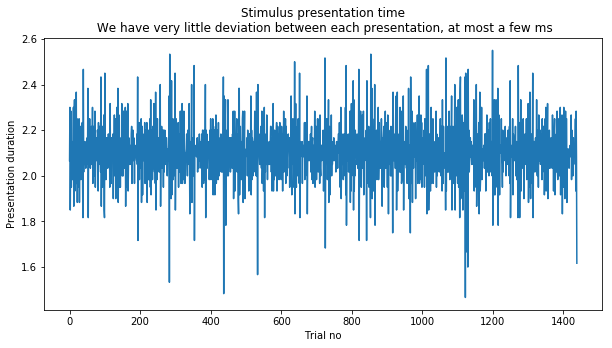

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(np.asarray(chunk_end_list[1:]) - np.asarray(chunk_end_list[:-1]))
plt.title('Stimulus presentation time\n We have very little deviation between each presentation, at most a few ms')
plt.xlabel('Trial no')
plt.ylabel('Presentation duration')
plt.show()

# Extracting spike times from clusters 

In [10]:
spike_times = np.load(subfolder+'spike_times.npy')
spike_clusters = np.load(subfolder+'spike_clusters.npy')

# group spike with cluster identity
spike_cluster_table = []
for i, spike in enumerate(spike_times):
    spike_cluster_table.append((spike[0], spike_clusters[i]))

# extract cluster metadata
cluster_groups = []
with open(subfolder+'./cluster_groups.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        if row[0].split('\t')[1] == 'good':
            cluster_groups.append(int(row[0].split('\t')[0]))

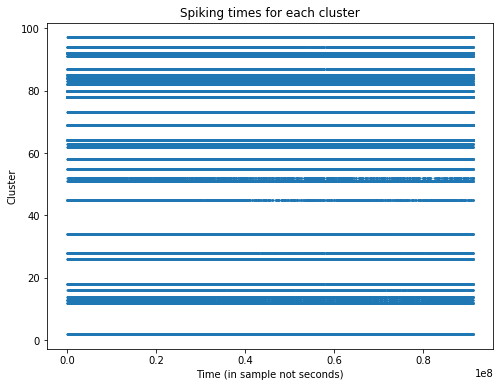

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(*zip(*spike_cluster_table), s=1)
plt.xlabel('Time (in sample not seconds)')
plt.ylabel('Cluster')
plt.title('Spiking times for each cluster')
plt.show()

In [12]:
good_spikes = []

for good_cluster in cluster_groups:
    temp_lst = []
    for spike_cluster in spike_cluster_table:
        if spike_cluster[-1] == good_cluster:
            temp_lst.append(spike_cluster[0]/30000+min_timestamps)

    good_spikes.append(temp_lst)

hist_list = []
for it, cluster in enumerate(good_spikes):
    #plt.figure(figsize=(4, 4))
    hist = plt.hist(cluster, bins=chunk_end_list)
    hist_list.append(hist[0])
    '''plt.xlabel('Time (s)')
    plt.ylabel('Spikes')
    plt.title('Spikes binned (matplotlib) per sequences for neuron cluster #%s' % it)
    plt.show()
    plt.pause(.1)'''

#plt.close('all')

In [13]:
#CAREFUL !!!!!!
# With MC one stimulus is end-end, not end-beg
#plt.figure(figsize=(12, 8))
cluster_spike_bins = []
for cluster in tqdm(good_spikes, 'Binning'):
    spike_bins = []

    for i in range(len(chunk_end_list)-1):
        where = np.where(
            (cluster >= chunk_end_list[i]) & (cluster <= chunk_end_list[i+1]-.5))[0]
        spike_bins.append(len(where))

    '''plt.ylabel('Spikes')
    plt.xlabel('Sequence #')
    plt.title('Spiked bin (custom)')
    plt.plot(spike_bins[::10])'''
    cluster_spike_bins.append(spike_bins)

Binning: 100%|██████████| 14/14 [01:26<00:00,  5.03s/it]


In [14]:
plt.close('all')

# Linking the results with the stimulation
For the gratings I don't have a stim file but I saved and controlled the code for each sequence, so I can re-generate it

This sequence is randomized with numpy's shuffler

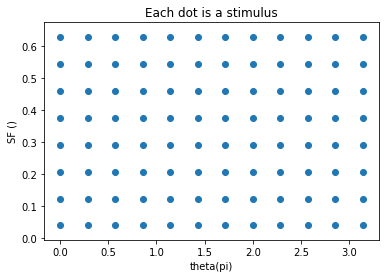

In [15]:
import itertools

# Orientations
N_thetas = 12
thetas = np.linspace(0,np.pi, N_thetas) # we offset by pi/2 to prevent problems with matplotlib's displays and psychopy

# Noise
B_thetas = [np.pi/32, np.pi/16, np.pi/8, np.pi/4, np.pi/2] 
B_thetas = np.linspace(np.pi/2, np.pi/32, 8)/2.5
# Presentation of each pattern
stim_duration = 2 #s

# Repetition of each block
repetition = 15

rng = np.random.RandomState(42)
sequence = list(itertools.product(thetas, B_thetas))
rng.shuffle(sequence)

plt.scatter(*zip(*sequence))
plt.title('Each dot is a stimulus')
plt.xlabel('theta(pi)')
plt.ylabel('SF ()')
plt.show()

In [16]:
full_sequences = sequence.copy()
for rep in range(repetition-1):
    full_sequences += sequence

In [17]:
del full_sequences[0] #initialization artifact removed

In [18]:
len(full_sequences) == len(chunk_end_list)-1

True

In [19]:
len(cluster_spike_bins[0])

1439

In [20]:
seq_FR_list = []
for it, cluster in enumerate(cluster_spike_bins):
    # print(it) #cluster number
    temp_list = []  # list of sequence info with firing rate
    for it2, sequence in enumerate(full_sequences):
        # print(it2) #sequence number
        i = it2-1
        FR = cluster[i] / (chunk_end_list[i+1] - chunk_end_list[i])
        temp_list.append((sequence, FR))

    seq_FR_list.append(temp_list)

In [21]:
all_unique_tuple_FR_list = []

for cluster in seq_FR_list:
    uniqs = np.unique(np.asarray(cluster)[:, 0])
    # first element is sequence info (theta,cpd) and second is FR summed on 5 repetitions
    unique_tuple_FR_list = []
    for unique_tuple in uniqs:
        sum_list = []
        for seq_fr in cluster:
            if seq_fr[0] == unique_tuple:
                sum_list.append(seq_fr[1])
        seq_sum = np.sum(sum_list)
        unique_tuple_FR_list.append((unique_tuple, seq_sum))

    all_unique_tuple_FR_list.append(unique_tuple_FR_list)

In [22]:
uniq_theta = thetas.copy()
uniq_b_theta = B_thetas.copy()

In [23]:
all_unique_tuple_FR_list[0]

[((0.0, 0.039269908169872414), 118.35057730870469),
 ((0.0, 0.12341971139102767), 109.79266097979712),
 ((0.0, 0.20756951461218281), 112.88100321122769),
 ((0.0, 0.291719317833338), 118.18669842147436),
 ((0.0, 0.37586912105449316), 113.8479910890051),
 ((0.0, 0.4600189242756483), 109.63812246225757),
 ((0.0, 0.5441687274968035), 85.95629133597504),
 ((0.0, 0.6283185307179586), 70.29901666516473),
 ((0.28559933214452665, 0.039269908169872414), 89.51221881046507),
 ((0.28559933214452665, 0.12341971139102767), 90.1266058801994),
 ((0.28559933214452665, 0.20756951461218281), 123.15450018497296),
 ((0.28559933214452665, 0.291719317833338), 128.49294943684745),
 ((0.28559933214452665, 0.37586912105449316), 87.52328840932319),
 ((0.28559933214452665, 0.4600189242756483), 136.72843673006295),
 ((0.28559933214452665, 0.5441687274968035), 121.89271031268382),
 ((0.28559933214452665, 0.6283185307179586), 100.0992118514179),
 ((0.5711986642890533, 0.039269908169872414), 71.44847729720762),
 ((0.5

# Global tuning curve (taking in account all noise levels)

In [24]:
from lmfit import Model, Parameters


def tuning_function(x, j, B, fmax):  # von mises, baseline is the minimum neuron activity
    N = len(x)
    if B == np.inf:
        VM = np.ones_like(x)
    else:
        VM = np.exp((np.cos(2.*np.pi*(x-j)/N)-1.)/4/(B*np.pi/180)**2)
    #VM /= VM.sum(axis=0)
    return fmax * VM


def fit_plot(array, datacol='.b', fitcol='k', data_kws=None, do_title=True,
             seq_nbr=None):

    # fit the gaussian
    x = np.linspace(0, len(array), len(array))
    y = array
    N = len(array)

    #mod = GaussianModel()

    mod = Model(tuning_function)
    pars = Parameters()
    y = y-np.min(y)
    pars.add_many(('j', y.argmax(), True,  0.0, N), ('B', 15., True,  0.1, 360),
                  ('fmax', y.max(), True,  0.0, 100.))

    #pars = mod.guess(y, x=x)
    #pars['center'] = lmfit.Parameter('center', seq_nbr*15)
    out = mod.fit(y, pars, x=x, nan_policy='omit')
    # print(out.fit_report(min_correl=0.25))

    '''# plot the fits
    out.plot_fit(datafmt=datacol, fitfmt=fitcol,
                 data_kws=data_kws, show_init=False)'''
    # print(out.fit_report())
    sigma = out.best_values['B']

    '''    
    if do_title:
        ax.set_title('Sequence #%s -- ' % seq_nbr + r'$B_\theta$ = %.2f' % sigma)'''
    return out.best_values, (1-out.residual.var() / np.var(y))

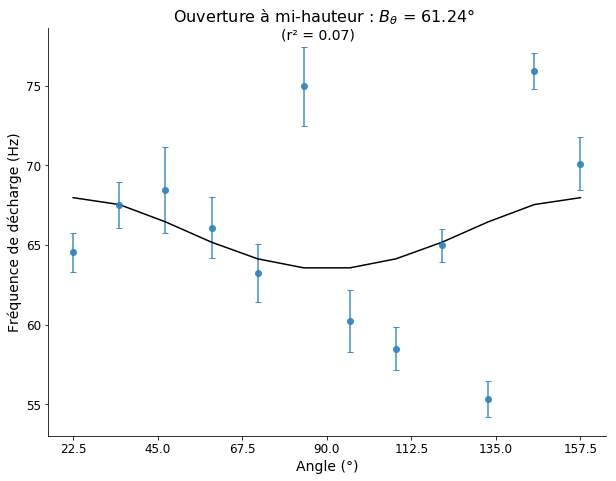

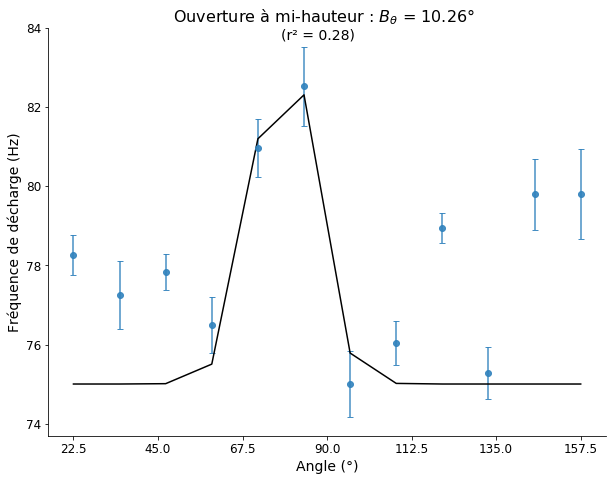

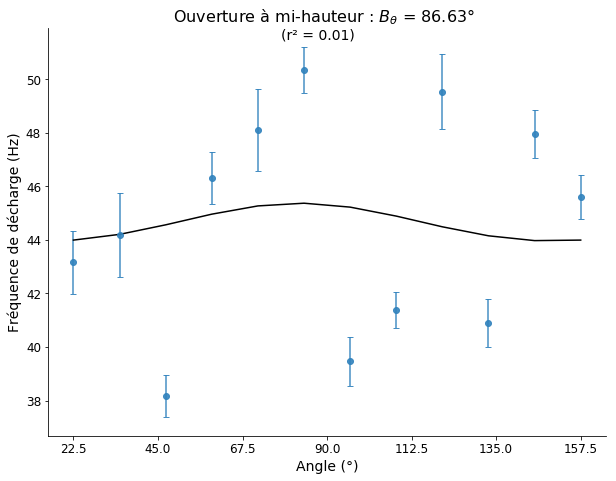

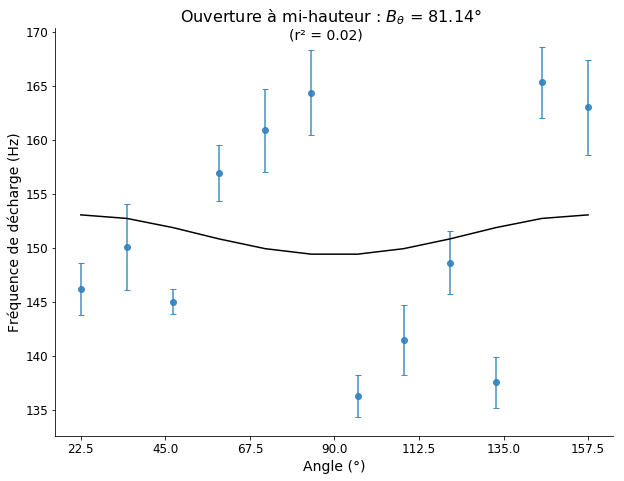

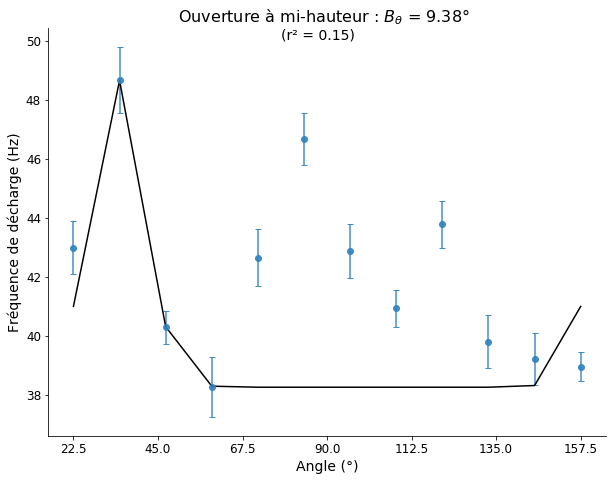

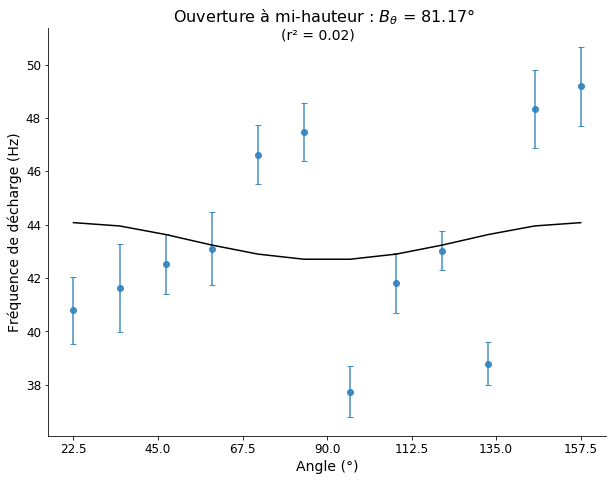

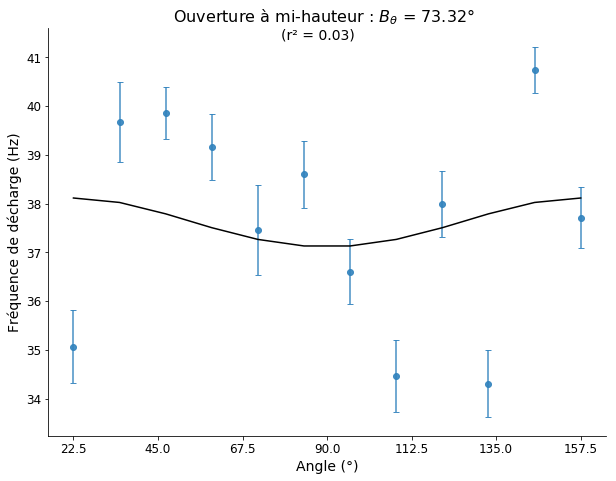

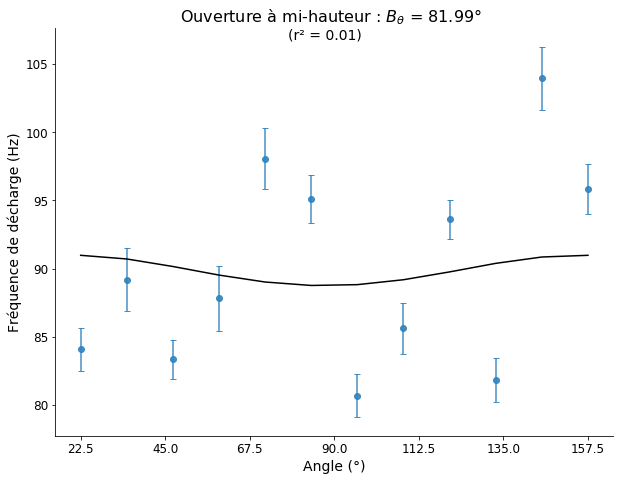

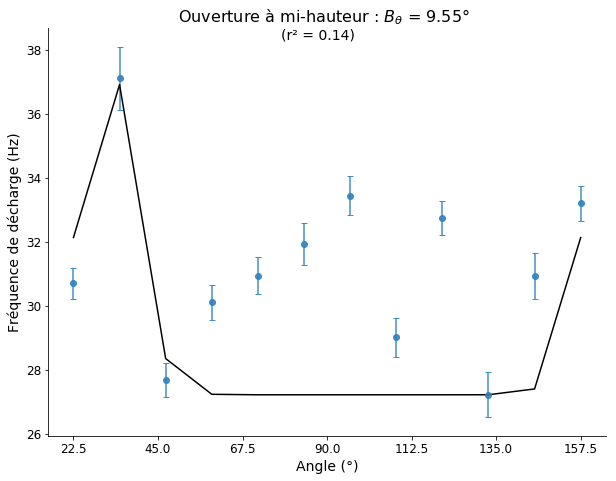

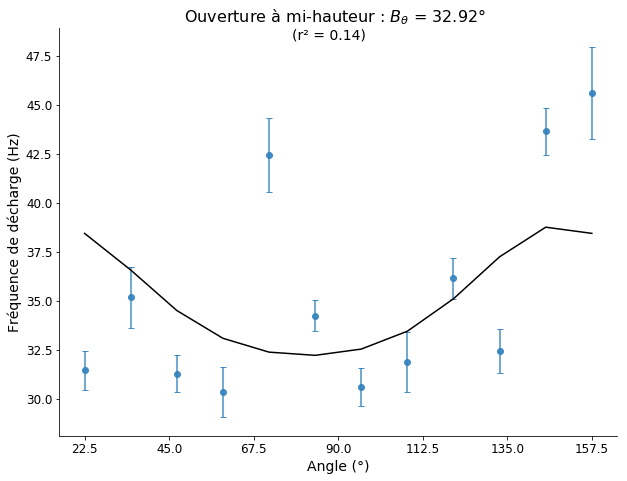

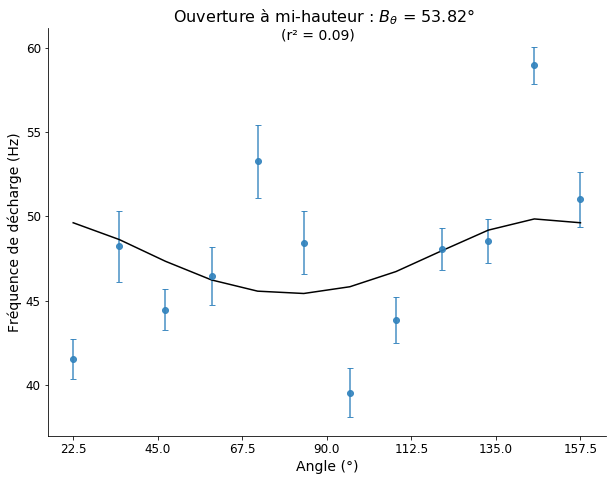

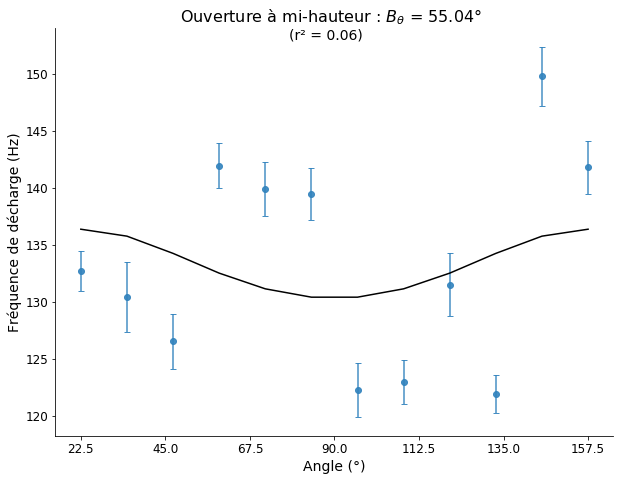

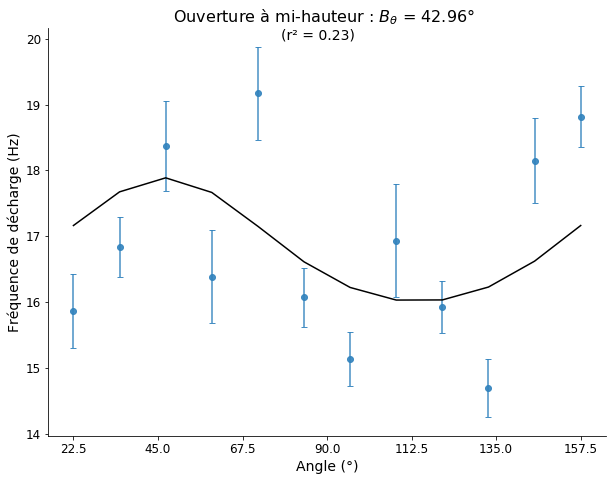

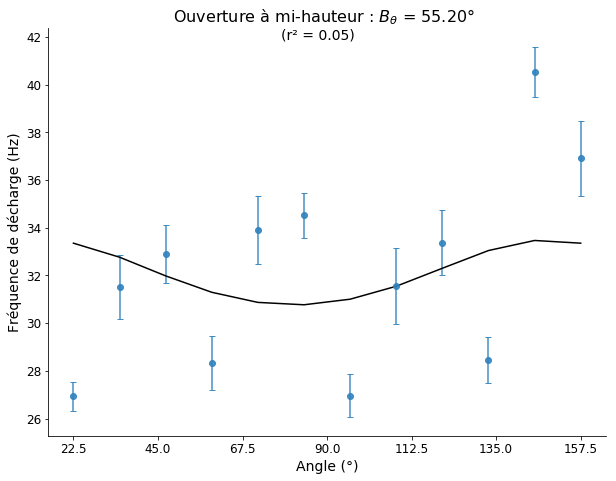

In [25]:
# we can sum along theta, which is likely to be uninformative due to noise in certains patterns

for it, neuron in enumerate(all_unique_tuple_FR_list):
    FR_sum = []
    FR_ind = []
    for thetas in uniq_theta:
        theta_sum_list = []
        for tup_fr in neuron:
            if tup_fr[0][0] == thetas:
                theta_sum_list.append(tup_fr[1])

        FR_sum.append(np.sum(theta_sum_list))
        FR_ind.append(theta_sum_list)
    xs = np.linspace(0, len(FR_sum), len(FR_sum))
    fig = plt.figure(figsize=(10, 7.5))
    ax = plt.subplot(111)

    best_vals = fit_plot(np.asarray(FR_sum)/(5+8))[0]
    fit_report = fit_plot(np.asarray(FR_sum)/(5+8))[1]


    for it3, theta in enumerate(FR_ind):
        ax.errorbar(xs[it3],
                    np.sum(FR_ind[it3])/(5+8),
                    np.std(FR_ind[it3])/(5+8), fmt='o', capsize=3,
                    c='#3182bd', alpha=.9)
    #ax.plot(xs, np.asarray(FR_sum)/(5+8), '.b')
    
    ax.plot(xs,
        tuning_function(x=xs,
                        j=best_vals['j'], fmax=best_vals['fmax'],
                        B=best_vals['B'])+(np.asarray(FR_sum)/(5+8)).min(),
        c='k')

    ax.set_ylabel('Fréquence de décharge (Hz)', fontsize=14)
    ax.set_xlabel('Angle (°)', fontsize=14)
    ax.set_title('Ouverture à mi-hauteur : ' + r'$B_\theta$ = %.2f°  ' %
                 best_vals['B'], fontsize=16)
    plt.suptitle('(r² = %.2f)' % fit_report, fontsize=14, y=.88)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = np.linspace(0, np.pi, len(labels))*180/np.pi

    ax.set_xticklabels(labels)

    ax.tick_params(axis='both', which='major', labelsize=12)
    #fig.savefig('./TC_MC_global/Global_TC_pen%s_N%s.svg' % (subfolder.split('/')[0], it), format='svg', transparent=True, bbox_inches='tight')
    plt.show()
    plt.close('all')

# Angle and noise dissociated (so 8 tuning curves per neuron)

neuron_to_plot = 2

all_btheta_list = []
for btheta in uniq_b_theta:
    theta_fr_perBtheta = []
    for theta in uniq_theta:
        for tup_theta_btheta in seq_FR_list[neuron_to_plot]:
            if tup_theta_btheta[0][0] == theta and tup_theta_btheta[0][1] == btheta:
                theta_fr_perBtheta.append(tup_theta_btheta)

    all_btheta_list.append(theta_fr_perBtheta)


for b_theta_curve in all_btheta_list:
    b_theta_points = []
    for theta in uniq_theta:
        theta_lst = []
        for tup in b_theta_curve:
            if tup[0][0] == theta:
                theta_lst.append(tup[1])
        b_theta_points.append(np.asarray(theta_lst))

    fig = plt.figure(figsize=(10, 7.5))
    ax = plt.subplot(111)

    xs = np.linspace(0, len(b_theta_points), len(b_theta_points))
    #FR_sum = np.sum(np.asarray(b_theta_points), axis=1)
    
    FR_sum = []
    FR_std = []
    for b_t in b_theta_points :
        FR_sum.append(np.sum(b_t))
        FR_std.append(np.std(b_t))

    best_vals = fit_plot(np.asarray(FR_sum))[0]
    fit_report = fit_plot(np.asarray(FR_sum))[1]

    ax.plot(xs,
            tuning_function(x=xs,
                            j=best_vals['j'], fmax=best_vals['fmax'],
                            B=best_vals['B'])+(np.asarray(FR_sum).min()),
            c='k')

    ax.errorbar(xs,
                FR_sum,
                FR_std, fmt='o', capsize=3,
                c='#3182bd', alpha=.9)

    ax.set_ylabel('Fréquence de décharge (Hz)', fontsize=14)
    ax.set_xlabel('Angle (°)', fontsize=14)
    ax.set_title(r'$B_\theta$ stim. = %.1f°  ;  ' % b_theta_curve[0][0][1] + r'$B_\theta$ = %.2f°' %
                 best_vals['B'], fontsize=16)
    plt.suptitle('(r² = %.2f)' % fit_report, fontsize=14, y=.88)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = np.linspace(0, np.pi, len(labels))*180/np.pi
    
    ax.set_xticklabels(labels)

    ax.tick_params(axis='both', which='major', labelsize=12)
    #fig.savefig('./TC_MC_Btheta/N%s_B_theta_TC_pen%s_CPD%.2f.svg' % (neuron_to_plot, subfolder.split('/')[0], b_theta_curve[0][0][1]),format='svg', transparent=True, bbox_inches='tight')
    
    psychometric_list.append((b_theta_curve[0][0][1], best_vals['B']))
    plt.show()
    plt.close('all')

In [26]:
#neuron_to_plot = 0

psychometric_list = []

for neuron_to_plot, _ in enumerate(good_spikes):
    temp_psycho_list = []
    all_btheta_list = []
    for btheta in uniq_b_theta:
        theta_fr_perBtheta = []
        for theta in uniq_theta:
            for tup_theta_btheta in seq_FR_list[neuron_to_plot]:
                if tup_theta_btheta[0][0] == theta and tup_theta_btheta[0][1] == btheta:
                    theta_fr_perBtheta.append(tup_theta_btheta)

        all_btheta_list.append(theta_fr_perBtheta)


    for b_theta_curve in all_btheta_list:
        
        b_theta_points = []
        for theta in uniq_theta:
            theta_lst = []
            for tup in b_theta_curve:
                if tup[0][0] == theta:
                    theta_lst.append(tup[1])
            b_theta_points.append(np.asarray(theta_lst))

        #fig = plt.figure(figsize=(10, 7.5))
        #ax = plt.subplot(111)

        xs = np.linspace(0, len(b_theta_points), len(b_theta_points))
        #FR_sum = np.sum(np.asarray(b_theta_points), axis=1)

        FR_sum = []
        FR_std = []
        for b_t in b_theta_points :
            FR_sum.append(np.sum(b_t))
            FR_std.append(np.std(b_t))

        best_vals = fit_plot(np.asarray(FR_sum))[0]
        fit_report = fit_plot(np.asarray(FR_sum))[1]

        ''' 
        ax.plot(xs,
                tuning_function(x=xs,
                                j=best_vals['j'], fmax=best_vals['fmax'],
                                B=best_vals['B'])+(np.asarray(FR_sum).min()),
                c='k')

        ax.errorbar(xs,
                    FR_sum,
                    FR_std, fmt='o', capsize=3,
                    c='#3182bd', alpha=.9)

        ax.set_ylabel('Fréquence de décharge (Hz)', fontsize=14)
        ax.set_xlabel('Angle (°)', fontsize=14)
        ax.set_title(r'$B_\theta$ stim. = %.1f°  ;  ' % b_theta_curve[0][0][1] + r'$B_\theta$ = %.2f°' %
                     best_vals['B'], fontsize=16)
        plt.suptitle('(r² = %.2f)' % fit_report, fontsize=14, y=.88)

        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        labels = np.linspace(0, np.pi, len(labels))*180/np.pi

        ax.set_xticklabels(labels)

        ax.tick_params(axis='both', which='major', labelsize=12)'''
        #fig.savefig('./TC_MC_Btheta/N%s_B_theta_TC_pen%s_CPD%.2f.svg' % (neuron_to_plot, subfolder.split('/')[0], b_theta_curve[0][0][1]),format='svg', transparent=True, bbox_inches='tight')

        temp_psycho_list.append((b_theta_curve[0][0][1], best_vals['B']))
        '''plt.show()
        plt.close('all')'''
        
    psychometric_list.append(temp_psycho_list)

In [27]:
len(psychometric_list)

14

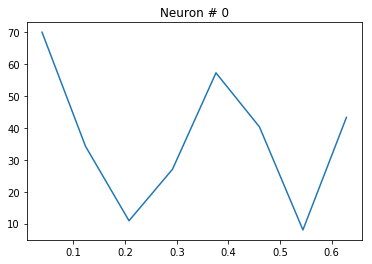

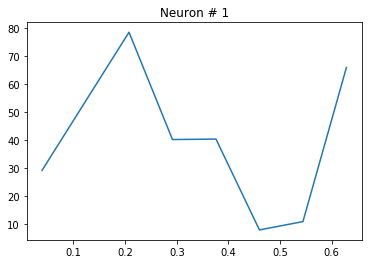

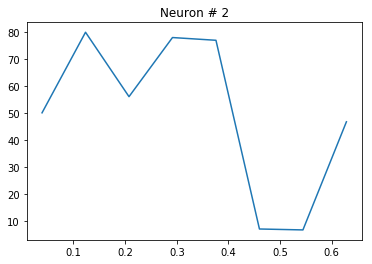

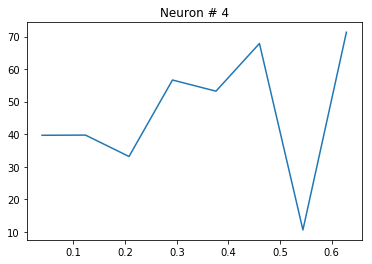

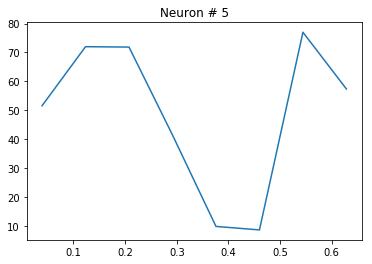

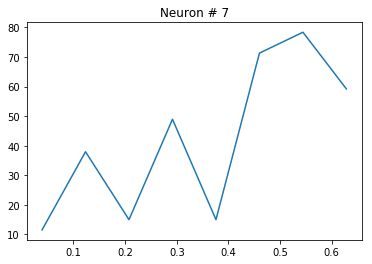

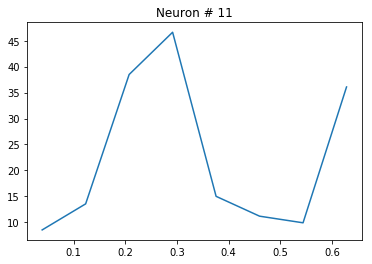

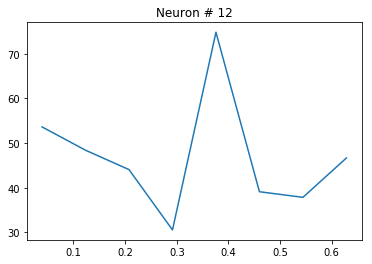

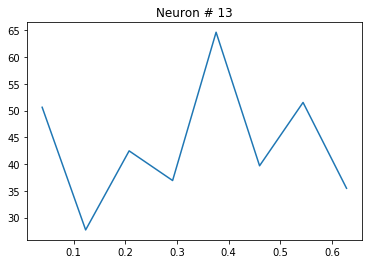

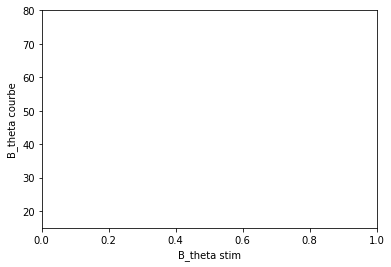

In [28]:
curated_psycho_list = []
for it, psych_list in enumerate(psychometric_list):
    if max(psych_list,key=lambda item:item[1])[1] < 80 or min(psych_list,key=lambda item:item[1])[1] == 15 : #limiter les nonfit
        plt.plot(*zip(*psych_list), label = it)
        curated_psycho_list.append(psych_list)
        
        plt.title('Neuron # %s' % it)
        plt.show()
        plt.pause(.05)

plt.ylabel('B_theta courbe')
plt.xlabel('B_theta stim')
plt.ylim(15, 80)
plt.show()

In [29]:
ndar_psychometric_list = np.asarray(psychometric_list) 
good_neurons = [1,2,3,4,11]
for good_neuron in good_neurons :
    np.save('./psychometric_arrays/PEN%s_N%s.npy' % (subfolder.split('/')[0],good_neuron),
            ndar_psychometric_list[good_neuron,:,1])

In [30]:
from os import listdir

listdir = listdir('./psychometric_arrays/')

curated_psycho_list = []
for file in listdir :
    arr = np.load('./psychometric_arrays/'+file)
    curated_psycho_list.append(arr)

In [ ]:
'./psychometric_arrays/PENH'

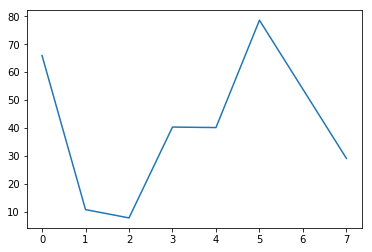

In [55]:
plt.plot(np.load('./psychometric_arrays/'+'PENH006_a17_N1.npy'))

[Text(0, 0, '36.0'),
 Text(0, 0, '31.2'),
 Text(0, 0, '26.4'),
 Text(0, 0, '21.5'),
 Text(0, 0, '16.7'),
 Text(0, 0, '11.9'),
 Text(0, 0, '7.1'),
 Text(0, 0, '2.2')]

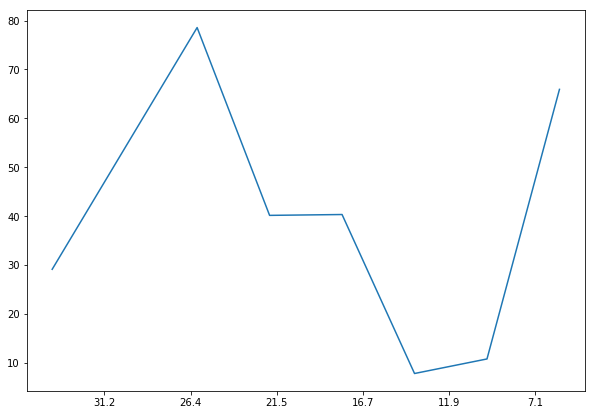

In [57]:
fig, ax = plt.subplots(figsize = (10,7))
plt.plot(ndar_psychometric_list[1, :, 0],
         np.load('./psychometric_arrays/'+'PENH006_a17_N1.npy'))

labels = [item.get_text() for item in ax.get_xticklabels()]
B_thetas2 = B_thetas.copy()[::-1]
labels = np.round(ndar_psychometric_list[1, :, 0]*180/np.pi,1)
ax.set_xticklabels(labels)

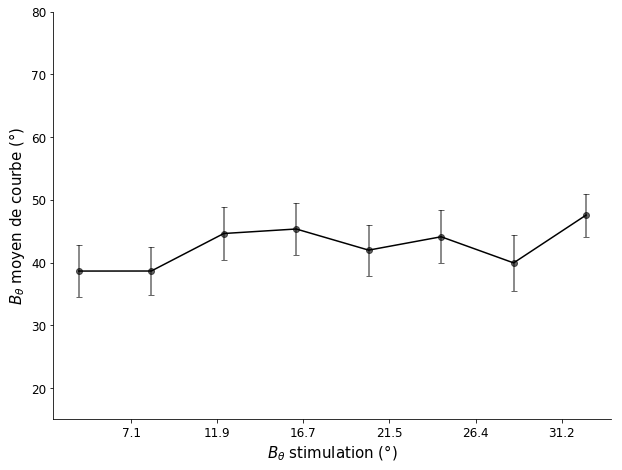

In [59]:
ndar_psychometric_list = np.asarray(psychometric_list)
# wups with a list it's going to be too tricky
arr_psychometric_list = np.asarray(curated_psycho_list)

stds = []
avgs = []
for btheta in range(len(uniq_b_theta)):
    tmp = []
    for curve in arr_psychometric_list:
        tmp.append(curve[btheta])
    stds.append(np.std(tmp)/np.sqrt(len(tmp)))
    avgs.append(np.mean(tmp))

fig = plt.figure(figsize=(10, 7.5))
ax = plt.subplot(111)


# REMEMBER THAT WE NEED TO FLIP THE ARRAYS BECAUSE OF THE ORDER BTHETA WAS SAVED
ax.plot(ndar_psychometric_list[1, :, 0], avgs, c = 'k')
ax.errorbar(ndar_psychometric_list[1, :, 0],
            avgs,
            stds, fmt='o', capsize=3,
            c='k', alpha=.6)

ax.set_ylabel(r'$B_\theta$ moyen de courbe (°)', fontsize=15)
ax.set_xlabel(r'$B_\theta$ stimulation (°)', fontsize=15)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = np.round(ndar_psychometric_list[1, :, 0][::-1]*180/np.pi,1)
ax.set_xticklabels(labels)

ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim(15, 80) #limits between which i allow b_theta to move
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
fig.savefig('Mean_btheta_population.svg', format='svg', transparent=True, bbox_inches='tight')
plt.show()

In [32]:
fit_per_b_theta  = []
for btheta in range(len(uniq_b_theta)):
    tmp = []
    for curve in arr_psychometric_list:
        tmp.append(curve[btheta])
    fit_per_b_theta.append(tmp)

In [33]:
import scikit_posthocs  # convenient module
from scipy.stats import kruskal

'''Compute the Kruskal-Wallis H-test for independent samples

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal.
It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. 
Note that rejecting the null hypothesis does not indicate which of the groups differs.
Post-hoc comparisons between groups are required to determine which groups are different.'''

print(kruskal(fit_per_b_theta[0], fit_per_b_theta[1],
              fit_per_b_theta[2], fit_per_b_theta[3],
              fit_per_b_theta[4], fit_per_b_theta[5],
              fit_per_b_theta[6], fit_per_b_theta[7]))

# dunn's posthoc is appropriate for unequal number of observation, which we happen to have here
# due to the init elimination
scikit_posthocs.posthoc_dunn(fit_per_b_theta)

KruskalResult(statistic=6.045203880368717, pvalue=0.5344811626203079)


,1,2,3,4,5,6,7,8
1,-1.000000,0.240502,0.829211,0.404110,0.807027,0.600681,0.099681,0.090268
2,0.240502,-1.000000,0.338052,0.734285,0.352645,0.515491,0.636452,0.602890
3,0.829211,0.338052,-1.000000,0.536187,0.977223,0.758304,0.152520,0.139335
4,0.404110,0.734285,0.536187,-1.000000,0.555164,0.755891,0.416736,0.389965
5,0.807027,0.352645,0.977223,0.555164,-1.000000,0.780123,0.160875,0.147137
6,0.600681,0.515491,0.758304,0.755891,0.780123,-1.000000,0.261447,0.241775
7,0.099681,0.636452,0.152520,0.416736,0.160875,0.261447,-1.000000,0.962048
8,0.090268,0.602890,0.139335,0.389965,0.147137,0.241775,0.962048,-1.000000


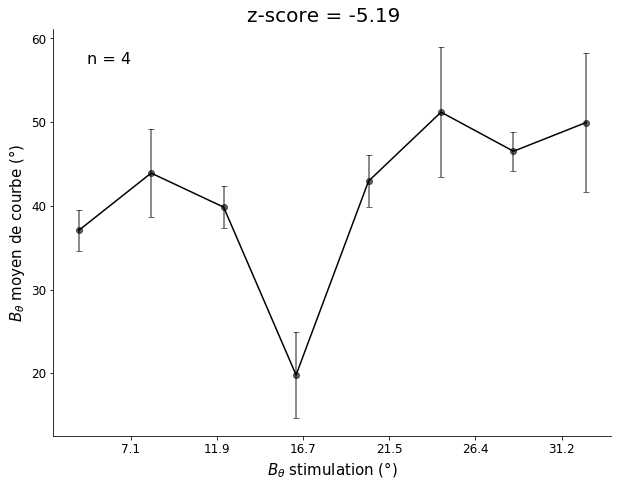

In [60]:
#plotting a neuron with a specific noise preference
neurons_to_plot = ['./psychometric_arrays/PENE008_a17_N4.npy',
                  './psychometric_arrays/PENF006_a17_N15.npy',
                  './psychometric_arrays/PENG007_a17_N11.npy',
                  './psychometric_arrays/PENG007_a17_N17.npy']

mean_curated = [] 
std_curated = []
fit_per_b_theta = []
for btheta in range(len(uniq_b_theta)):
    tmp = []
    for curve in neurons_to_plot:
        tmp.append(np.load(curve)[btheta])
    fit_per_b_theta.append(tmp)
    std_curated.append(np.std(tmp)/np.sqrt(len(tmp)))
    mean_curated.append(np.mean(tmp))
    
mean_curated = np.asarray(mean_curated)
#compute a z-score
excluded = np.min(mean_curated)
others = np.delete(mean_curated,
                   mean_curated.argmin())
z_score = (excluded-np.mean(others))/np.std(others) #(x-mu)/sigma iirc ?

fig = plt.figure(figsize=(10, 7.5))
ax = plt.subplot(111)

ax.errorbar(ndar_psychometric_list[1,:,0],
           mean_curated,
           std_curated,
            fmt='o', capsize=3,
            c='k', alpha=.6)
ax.plot(ndar_psychometric_list[1,:,0], mean_curated, color = 'k')

ax.set_ylabel(r'$B_\theta$ moyen de courbe (°)', fontsize=15)
ax.set_xlabel(r'$B_\theta$ stimulation (°)', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = np.round(ndar_psychometric_list[1, :, 0][::-1]*180/np.pi,1)
ax.set_xticklabels(labels)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_title('n = %s'%len(neurons_to_plot), x = .1, y = .90, fontsize = 16)
plt.suptitle('z-score = %.2f' % z_score, y = .92, fontsize = 20)

fig.savefig('neurometric_avg_curve_%.2fangle.svg' %(77.1), format='svg', transparent=True, bbox_inches='tight')
plt.show()
plt.close('all')

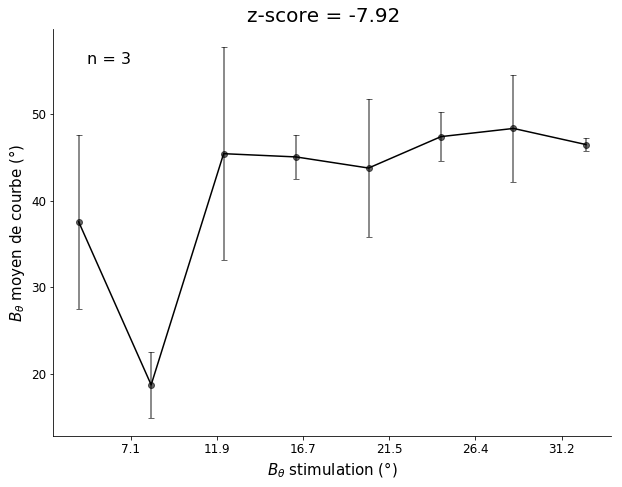

In [61]:
#plotting a neuron with a specific noise preference
neurons_to_plot = ['./psychometric_arrays/PENA007_a17_N14.npy',
                   './psychometric_arrays/PENB008_a17_N3.npy',
                   './psychometric_arrays/PENE008_a17_N10.npy']

mean_curated = [] 
std_curated = []
fit_per_b_theta = []
for btheta in range(len(uniq_b_theta)):
    tmp = []
    for curve in neurons_to_plot:
        tmp.append(np.load(curve)[btheta])
    fit_per_b_theta.append(tmp)
    std_curated.append(np.std(tmp)/np.sqrt(len(tmp)))
    mean_curated.append(np.mean(tmp))
    
mean_curated = np.asarray(mean_curated)
#compute a z-score
excluded = np.min(mean_curated)
others = np.delete(mean_curated,
                   mean_curated.argmin())
z_score = (excluded-np.mean(others))/np.std(others) #(x-mu)/sigma iirc ?

fig = plt.figure(figsize=(10, 7.5))
ax = plt.subplot(111)

ax.errorbar(ndar_psychometric_list[1,:,0],
           mean_curated,
           std_curated,
            fmt='o', capsize=3,
            c='k', alpha=.6)
ax.plot(ndar_psychometric_list[1,:,0], mean_curated, color = 'k')

ax.set_ylabel(r'$B_\theta$ moyen de courbe (°)', fontsize=15)
ax.set_xlabel(r'$B_\theta$ stimulation (°)', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = np.round(ndar_psychometric_list[1, :, 0][::-1]*180/np.pi,1)
ax.set_xticklabels(labels)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_title('n = %s'%len(neurons_to_plot), x = .1, y = .90, fontsize = 16)
plt.suptitle('z-score = %.2f' % z_score, y = .92, fontsize = 20)

fig.savefig('neurometric_avg_curve_%.2fangle.svg' %(26.1), format='svg', transparent=True, bbox_inches='tight')
plt.show()
plt.close('all')

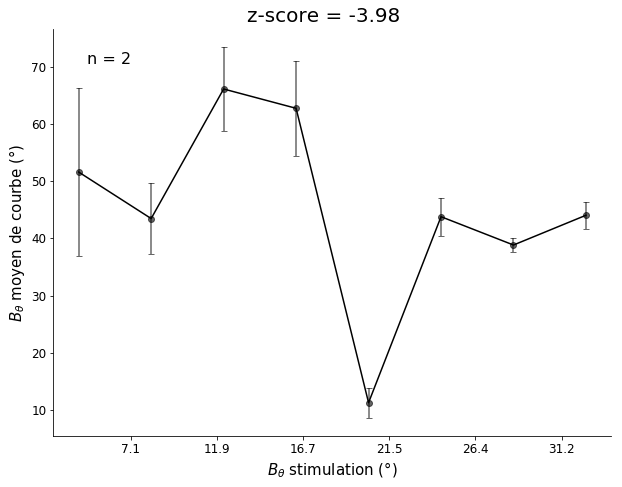

In [62]:
#plotting a neuron with a specific noise preference
neurons_to_plot = ['./psychometric_arrays/PENA007_a17_N17.npy',
                   './psychometric_arrays/PENF006_a17_N1.npy']

mean_curated = [] 
std_curated = []
fit_per_b_theta = []
for btheta in range(len(uniq_b_theta)):
    tmp = []
    for curve in neurons_to_plot:
        tmp.append(np.load(curve)[btheta])
    fit_per_b_theta.append(tmp)
    std_curated.append(np.std(tmp)/np.sqrt(len(tmp)))
    mean_curated.append(np.mean(tmp))
    
mean_curated = np.asarray(mean_curated)
#compute a z-score
excluded = np.min(mean_curated)
others = np.delete(mean_curated,
                   mean_curated.argmin())
z_score = (excluded-np.mean(others))/np.std(others) #(x-mu)/sigma iirc ?

fig = plt.figure(figsize=(10, 7.5))
ax = plt.subplot(111)

ax.errorbar(ndar_psychometric_list[1,:,0],
           mean_curated,
           std_curated,
            fmt='o', capsize=3,
            c='k', alpha=.6)
ax.plot(ndar_psychometric_list[1,:,0], mean_curated, color = 'k')

ax.set_ylabel(r'$B_\theta$ moyen de courbe (°)', fontsize=15)
ax.set_xlabel(r'$B_\theta$ stimulation (°)', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = np.round(ndar_psychometric_list[1, :, 0][::-1]*180/np.pi,1)
ax.set_xticklabels(labels)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_title('n = %s'%len(neurons_to_plot), x = .1, y = .90, fontsize = 16)
plt.suptitle('z-score = %.2f' % z_score, y = .92, fontsize = 20)

fig.savefig('neurometric_avg_curve_%.2fangle.svg' %(90), format='svg', transparent=True, bbox_inches='tight')
plt.show()
plt.close('all')

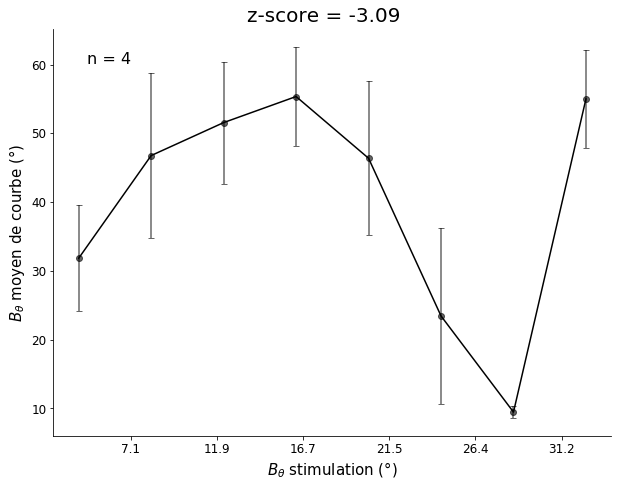

In [63]:
#plotting a neuron with a specific noise preference
neurons_to_plot = ['./psychometric_arrays/PENH006_a17_N4.npy',
                  './psychometric_arrays/PENH006_a17_N2.npy',
                  './psychometric_arrays/PENH006_a17_N1.npy',
                  './psychometric_arrays/PENH006_a17_N11.npy']

mean_curated = [] 
std_curated = []
fit_per_b_theta = []
for btheta in range(len(uniq_b_theta)):
    tmp = []
    for curve in neurons_to_plot:
        tmp.append(np.load(curve)[btheta])
    fit_per_b_theta.append(tmp)
    std_curated.append(np.std(tmp)/np.sqrt(len(tmp)))
    mean_curated.append(np.mean(tmp))
    
mean_curated = np.asarray(mean_curated)
#compute a z-score
excluded = np.min(mean_curated)
others = np.delete(mean_curated,
                   mean_curated.argmin())
z_score = (excluded-np.mean(others))/np.std(others) #(x-mu)/sigma iirc ?

fig = plt.figure(figsize=(10, 7.5))
ax = plt.subplot(111)

ax.errorbar(ndar_psychometric_list[1,:,0],
           mean_curated,
           std_curated,
            fmt='o', capsize=3,
            c='k', alpha=.6)
ax.plot(ndar_psychometric_list[1,:,0], mean_curated, color = 'k')

ax.set_ylabel(r'$B_\theta$ moyen de courbe (°)', fontsize=15)
ax.set_xlabel(r'$B_\theta$ stimulation (°)', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = np.round(ndar_psychometric_list[1, :, 0][::-1]*180/np.pi,1)
ax.set_xticklabels(labels)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_title('n = %s'%len(neurons_to_plot), x = .1, y = .90, fontsize = 16)
plt.suptitle('z-score = %.2f' % z_score, y = .92, fontsize = 20)

fig.savefig('neurometric_avg_curve_%.2fangle.svg' %(130), format='svg', transparent=True, bbox_inches='tight')
plt.show()
plt.close('all')

#plotting a neuron with a specific noise preference
neurons_to_plot = ['./psychometric_arrays/PENE008_a17_N4.npy',
                  './psychometric_arrays/PENF006_a17_N15.npy',
                  #'./psychometric_arrays/PENG007_a17_N11.npy',
                  './psychometric_arrays/PENG007_a17_N17.npy']

mean_curated = [] 
max_curated = []
min_curated = []
for btheta in range(len(uniq_b_theta)):
    tmp = []
    for curve in neurons_to_plot:
        tmp.append(np.load(curve)[btheta])
    min_curated.append(np.min(tmp))
    max_curated.append(np.max(tmp))
    mean_curated.append(np.mean(tmp))
    

        
fig = plt.figure(figsize=(10, 7.5))
ax = plt.subplot(111)

ax.fill_between(ndar_psychometric_list[1,:,0],
                min_curated,
                max_curated,
                color='gray', alpha = .5) 
ax.plot(ndar_psychometric_list[1,:,0], mean_curated, color = 'w')

ax.set_ylabel(r'$B_\theta$ moyen de courbe (°)', fontsize=15)
ax.set_xlabel(r'$B_\theta$ stimulation (°)', fontsize=15)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = np.round(np.linspace(0, np.pi, len(labels))*180/np.pi,1)

ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#fig.savefig('./TC_MC_global/Global_TC_pen%s_N%s.svg' % (subfolder.split('/')[0], it), format='svg', transparent=True, bbox_inches='tight')
plt.show()
plt.close('all')

#plotting a neuron with a specific noise preference
neurons_to_plot = ['./psychometric_arrays/PENA007_a17_N14.npy',
                   './psychometric_arrays/PENB008_a17_N3.npy']


fig = plt.figure(figsize=(10, 7.5))
ax = plt.subplot(111)

colors=plt.cm.viridis(np.linspace(.1,.9,4))
for it, neuron_to_plot in enumerate(neurons_to_plot):
    ax.plot(ndar_psychometric_list[1,:,0], np.load(neuron_to_plot), 
           mc = colors[it])

ax.set_ylabel(r'$B_\theta$ moyen de courbe (°)', fontsize=15)
ax.set_xlabel(r'$B_\theta$ stimulation (°)', fontsize=15)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = np.round(np.linspace(0, np.pi, len(labels))*180/np.pi,1)

ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#fig.savefig('./TC_MC_global/Global_TC_pen%s_N%s.svg' % (subfolder.split('/')[0], it), format='svg', transparent=True, bbox_inches='tight')
plt.show()
plt.close('all')